# Análise exploratória dos dados

Este notebook deve ser lido após os `business_and_data_understanding` e também após a execução do script `get_data` caso seja necessário obter os dados novamente.

Como não colocamos uma forma de retry nas requisições é possível que muitas pautas não tenham sido obtidas por uma instabilidade nos links e na rede da câmara.

Os dados obtidos foram da semana 29/06/2025 a 05/06/2025.

Vamos ler os arquivos CSV contendo os dados que obtivemos com os scritps.

In [1]:
# !pip install matplotlib
# !pip install seaborn
# !pip install wordcloud
# !pip install spacy
# !pip install transformers
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install umap-learn
# !pip install numpy==2.2.0
# !pip install datasets
# !pip install scikit-learn
# !pip install umap-learn

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

import seaborn as sns
import spacy
from collections import Counter, defaultdict

from umap import UMAP
from datasets import Dataset

from sklearn.preprocessing import MinMaxScaler

import torch


from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import matplotlib.pyplot as plt


c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !python -m spacy download pt_core_news_sm

In [4]:
nlp = spacy.load("pt_core_news_sm")

In [5]:
%cd ..

c:\Users\renne\Documents\repos\legislativo-nlp


In [6]:
events_with_topics = pd.read_csv("data/datasets/events_with_topics.csv", encoding="utf-8-sig")
motions = pd.read_csv("data/datasets/motions.csv", encoding="utf-8-sig")

In [7]:
events_with_topics.head()

,id,uri,dataHoraInicio,dataHoraFim,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,urlRegistro,details,topics
0,75866,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-15T09:00,NaN,Agendada,Sessão Não Deliberativa Solene,Homenagem ao Dia do Esporte\r\n Homenagem ao D...,NaN,"[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': 'Plenário da Câmara dos Deputados', '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
1,76380,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-18T19:00,NaN,Convocada,Simpósio,Abertura da 19ª edição do projeto Politea\r\n ...,NaN,"[{'id': 100950, 'uri': 'https://dadosabertos.c...","{'nome': 'Auditório Nereu Ramos', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
2,76582,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-15T14:00,NaN,Convocada,Audiência Pública,Sustentabilidade na Produção e Comercialização...,NaN,"[{'id': 2004, 'uri': 'https://dadosabertos.cam...","{'nome': 'Anexo II, Plenário 08', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
3,76801,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-17T16:00,NaN,Convocada,Seminário,Aspectos legais e ambientais relativos à impla...,Câmara Municipal de Saquarema,"[{'id': 6174, 'uri': 'https://dadosabertos.cam...","{'nome': None, 'predio': None, 'sala': None, '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
4,76873,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-16T14:30,NaN,Convocada,Audiência Pública,"Projeto de Lei nº 761/2025, de autoria do Depu...",NaN,"[{'id': 2001, 'uri': 'https://dadosabertos.cam...","{'nome': 'A Definir', 'predio': None, 'sala': ...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN


Vemos que os arquivos foram salvos corretamente, apenas temos a transformações dos None originais para NaN.

In [8]:
events_with_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60 non-null     int64  
 1   uri             60 non-null     object 
 2   dataHoraInicio  60 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        60 non-null     object 
 5   descricaoTipo   60 non-null     object 
 6   descricao       60 non-null     object 
 7   localExterno    12 non-null     object 
 8   orgaos          60 non-null     object 
 9   localCamara     60 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         60 non-null     object 
 12  topics          13 non-null     object 
dtypes: float64(2), int64(1), object(10)
memory usage: 6.2+ KB


In [9]:
events_with_topics.describe(include="object")


,uri,dataHoraInicio,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,details,topics
count,60,60,60,60,60,12,60,60,60,13
unique,60,29,3,12,52,11,36,18,60,13
top,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-16T10:00,Convocada,Audiência Pública,Discussão e votação de propostas legislativas,"Anexo II, Pav. Superior, Ala C, sala 176","[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': None, 'predio': None, 'sala': None, '...","{'uriDeputados': None, 'uriConvidados': None, ...",Pauta - CEXCIRS - 14/07/2025 10:00\nCÂMARA DOS...
freq,1,7,55,20,9,2,5,12,1,1


In [10]:
print(f"Eventos com pauta {events_with_topics.shape[0] - events_with_topics.topics.isnull().sum()}")

Eventos com pauta 13


Temos que apenas 35 pautas foram resgatadas, o que é menos que a metade dos eventos, como comentado previamente, podem ter ocorrido problemas na conexão com a página ou elas não estão disponíveis.

In [11]:
events_with_topics.descricaoTipo.value_counts()

descricaoTipo
Audiência Pública                  20
Reunião Deliberativa               20
Mesa Redonda                        4
Seminário                           3
Reunião Técnica                     3
Sessão Não Deliberativa Solene      2
Audiência Pública e Deliberação     2
Comissão Geral                      2
Simpósio                            1
Visita Técnica                      1
Reunião de Eleição                  1
Sessão Deliberativa                 1
Name: count, dtype: int64

Para a próxima semana o evento de maior predominância é de Audiência Pública, seguido de Reuniões deliberativas.

In [12]:
events_with_topics.situacao.value_counts()

situacao
Convocada    55
Agendada      4
Cancelada     1
Name: count, dtype: int64

Conseguimos visualizar também os 3 tipos de situação, onde a maioria (75) está convocada, 4 agendadas e apenas 1 cancelada.

Para visualizarmos os órgão que os eventos se referem precisamos tratar essa coluna e retirá-la do JSON original. Vamos considerar inicialmente que um evento pode possuir apenas uma comissão a que se refere.

In [13]:
events_with_topics.orgaos.iloc[0]

"[{'id': 180, 'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/180', 'sigla': 'PLEN', 'nome': 'Plenário', 'apelido': 'Plenário', 'codTipoOrgao': 26, 'tipoOrgao': 'Plenário Virtual', 'nomePublicacao': 'Plenário', 'nomeResumido': 'Plenário'}]"

In [14]:
def extract_comission(orgao):
    try:
        orgaos = ast.literal_eval(orgao)  # Converte string para lista de dicts

        first_comission = orgaos[0].get("nome")
        return first_comission
    except Exception as e:
        print(f"Erro ao processar: {e}")
        return None

# Aplicar no DataFrame
events_with_topics["comission"] = events_with_topics["orgaos"].apply(extract_comission)

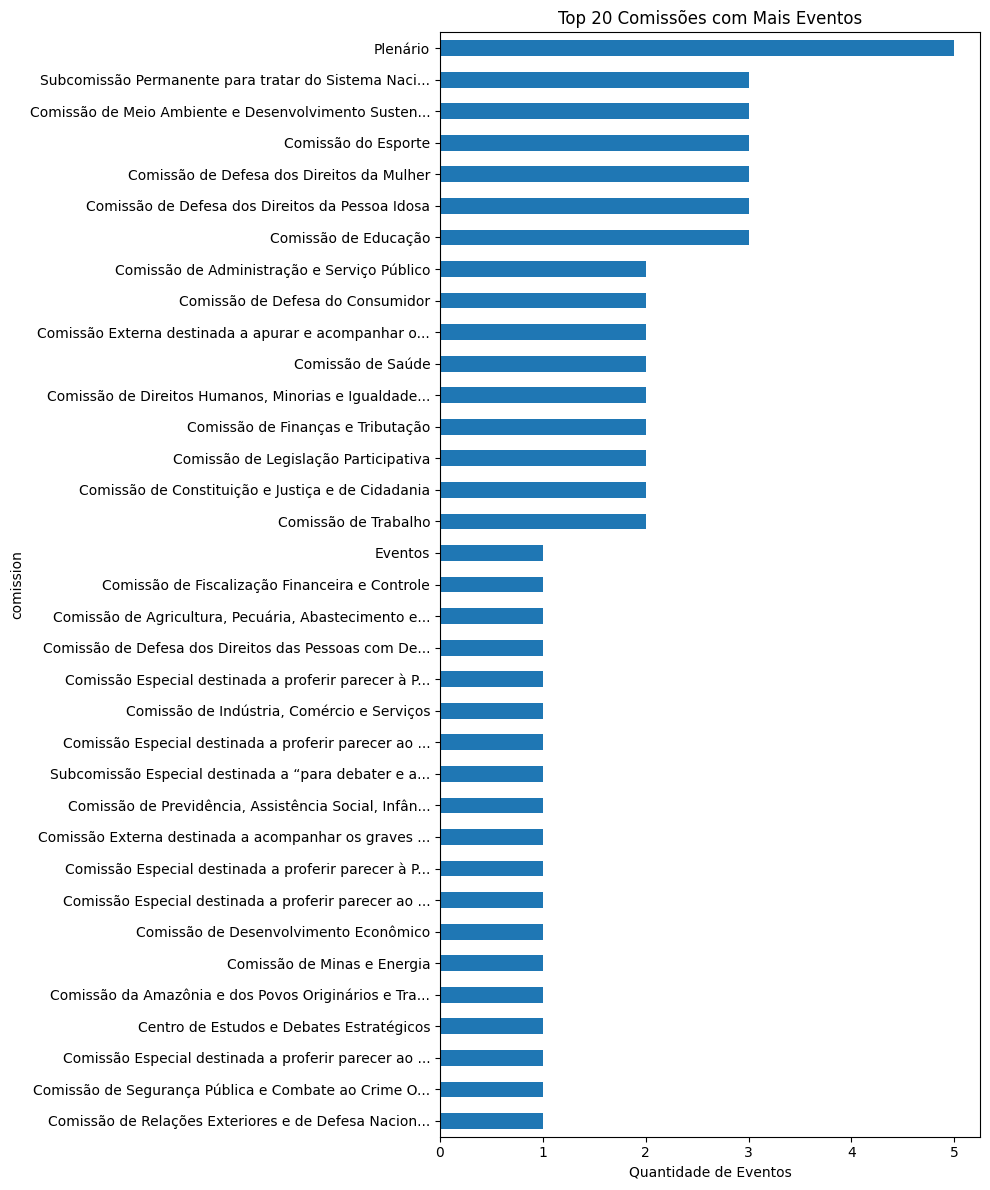

In [15]:
contagem_comissoes = events_with_topics["comission"].value_counts()

plt.figure(figsize=(10, 12))
ax = contagem_comissoes.plot(kind="barh")
plt.title("Top 20 Comissões com Mais Eventos")
plt.xlabel("Quantidade de Eventos")
plt.gca().invert_yaxis()
max_len = 50
yticklabels = [
    label.get_text()[:max_len] + "..." if len(label.get_text()) > max_len else label.get_text()
    for label in ax.get_yticklabels()
]
ax.set_yticklabels(yticklabels)

plt.tight_layout()
plt.show()

Temos a maioria dos eventos pela comissão de Educação seguido se sessões plenárias e posteriormente Comissão de segurança.

Vamos analisar os tamanhos das descrições e pautas.

Text(0.5, 1.0, 'Distribuição do Tamanho das descrições dos Eventos')

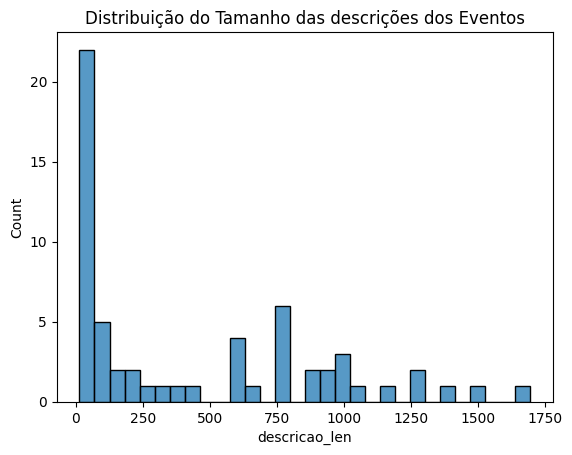

In [16]:
events_with_topics["descricao_len"] = events_with_topics["descricao"].str.len()
not_null_description_len = events_with_topics["descricao_len"].dropna()

sns.histplot(not_null_description_len, bins=30)
plt.title("Distribuição do Tamanho das descrições dos Eventos")

Text(0.5, 1.0, 'Distribuição do Tamanho das Pautas dos Eventos')

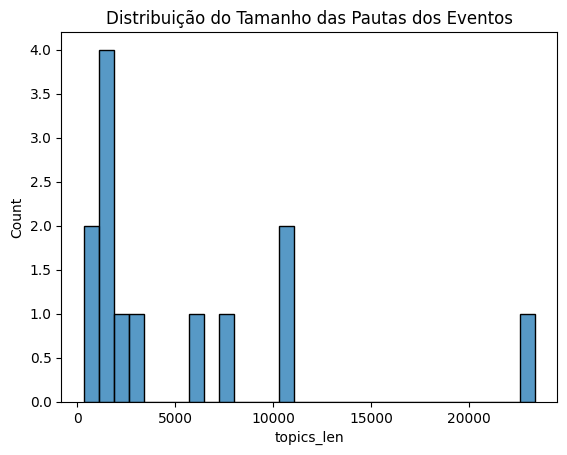

In [17]:
events_with_topics["topics_len"] = events_with_topics["topics"].str.len()
not_null_topics_len = events_with_topics["topics_len"].dropna()


sns.histplot(not_null_topics_len, bins=30)
plt.title("Distribuição do Tamanho das Pautas dos Eventos")


---

Vamos partir agora para a análise dos dados de requerimentos.

In [18]:
motions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   titulo    59 non-null     object
 1   uri       59 non-null     object
 2   event_id  59 non-null     int64 
 3   details   59 non-null     object
 4   status    59 non-null     object
 5   ementa    59 non-null     object
 6   pdf_url   59 non-null     object
 7   id        59 non-null     object
 8   pdf_text  59 non-null     object
dtypes: int64(1), object(8)
memory usage: 4.3+ KB


Temos 68 requerimentos para os 80 eventos, por hora foi decidido não agregá-los, então vamos analisá-los separadamente.

Todos os requerimentos apresentam campos não nulos, ou seja foi possível resgatar informações inclusive do PDF de todos.

In [19]:
motions.tail()

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
54,REQ 55/2025 CASP,https://dadosabertos.camara.leg.br/api/v2/prop...,77302,"{'id': 2529118, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer que seja autorizada pela Comissão de Ad...,https://www.camara.leg.br/proposicoesWeb/prop_...,55_2025,.\n\nP\nS\nA\nC\n-\n7\n7\n5\n0\n1\n:\n5\n1\n:\...
55,REQ 56/2025 CASP,https://dadosabertos.camara.leg.br/api/v2/prop...,77302,"{'id': 2529119, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer que seja autorizada pela Comissão de Ad...,https://www.camara.leg.br/proposicoesWeb/prop_...,56_2025,.\n\nP\nS\nA\nC\n-\n0\n6\n0\n1\n3\n:\n5\n2\n:\...
56,REQ 97/2025 CESPO,https://dadosabertos.camara.leg.br/api/v2/prop...,77312,"{'id': 2532661, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública com o...,https://www.camara.leg.br/proposicoesWeb/prop_...,97_2025,COMISSÃO DO ESPORTE \n\nREQUERIMENTO Nº ...
57,REQ 48/2025 CLP,https://dadosabertos.camara.leg.br/api/v2/prop...,77314,"{'id': 2516920, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de Audiência Pública para ...,https://www.camara.leg.br/proposicoesWeb/prop_...,48_2025,CÂMARA DOS DEPUTADOS\nGabinete Deputado João D...
58,REQ 97/2025 CESPO,https://dadosabertos.camara.leg.br/api/v2/prop...,77315,"{'id': 2532661, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública com o...,https://www.camara.leg.br/proposicoesWeb/prop_...,97_2025,COMISSÃO DO ESPORTE \n\nREQUERIMENTO Nº ...


Vamos verificar se não há duplicatas

In [20]:
motions.duplicated(subset=["id"]).sum()

np.int64(11)

Temos requerimentos com duplicatas nos IDs! Isso levanta uma necessidade de análise, foi identificado que requerimentos podem ter IDs iguais porém textos diferentes! Isso torna uma necessidade de resgatarmos os dados novamente pois os pdfs foram salvos com base inicialmente no ID.

In [21]:
motions[motions["id"] == '1_2025']

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
22,REQ 1/2025 CEXRSFEM,https://dadosabertos.camara.leg.br/api/v2/prop...,77154,"{'id': 2520689, 'uri': 'https://dadosabertos.c...",Aguardando Deliberação,"Requer a realização de 2 (dois) Seminários, a ...",https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,CÂMARA DOS DEPUTADOS\n\nCOMISSÃO EXTERNA SOBRE...
25,REQ 1/2025 PL233823,https://dadosabertos.camara.leg.br/api/v2/prop...,77186,"{'id': 2514511, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública para ...,https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,COMISSÃO ESPECIAL SOBRE INTELIGÊNCIA ARTIFICIA...


Text(0.5, 1.0, 'Distribuição do Tamanho dos títulos dos Requerimentos')

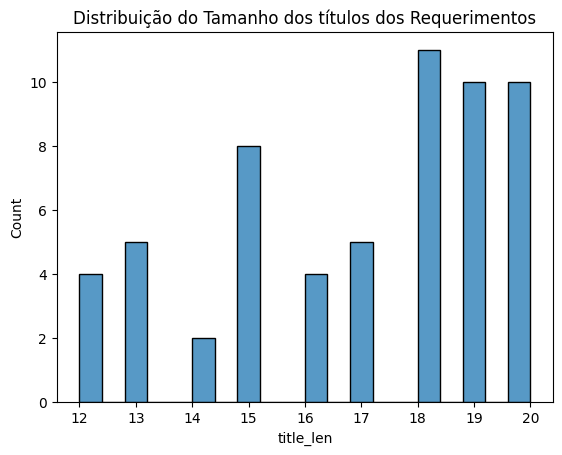

In [22]:
motions["title_len"] = motions["titulo"].str.len()
sns.histplot(motions["title_len"], bins=20)
plt.title("Distribuição do Tamanho dos títulos dos Requerimentos")

Temos que os títulos são realmente curtos e variam de  12 a 20 caracteres.

Temos nas ementas dos requerimentos um sumário do que ele se refere.

In [23]:
motions["ementa"].str.len().describe()
motions["ementa"].sample(5)

42    Requer seja transformada Sessão Plenária da Câ...
40    Requer a realização de Audiência Pública para ...
57    Requer a realização de Audiência Pública para ...
49    Requer que seja convidada a Exma. Sra. Macaé E...
37    Requer a realização de Audiência Pública no âm...
Name: ementa, dtype: object

Text(0.5, 1.0, 'Distribuição do Tamanho da Ementa')

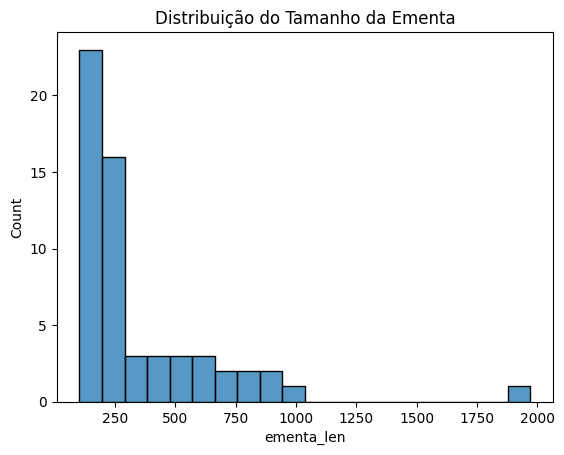

In [24]:
motions["ementa_len"] = motions["ementa"].str.len()
sns.histplot(motions["ementa_len"], bins=20)
plt.title("Distribuição do Tamanho da Ementa")

Verificamos que a maioria das ementas se encontra entre 100 e 300 caracteres, com predominância para 16 ementas com aproximados 250 caracteres.

Há uma ementa de 700 caracteres.

Text(0.5, 1.0, 'Distribuição do Tamanho do Requerimento em PDF')

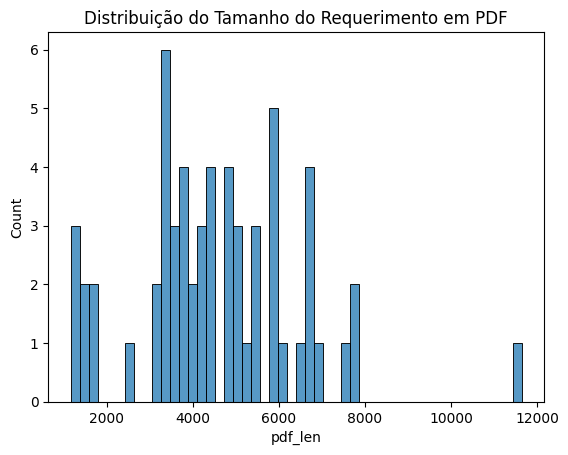

In [25]:
motions["pdf_len"] = motions["pdf_text"].str.len()
sns.histplot(motions["pdf_len"], bins=50)
plt.title("Distribuição do Tamanho do Requerimento em PDF")

In [26]:
motions["event_id"].value_counts().head()


event_id
77186    15
76955     5
77221     4
77224     3
77195     2
Name: count, dtype: int64

Temos para o evento de id 77007 a presença de 9 requerimentos! Mais que o dobro do que o segundo colocado com mais quantias.

<Axes: title={'center': 'Situação dos Requerimentos'}, ylabel='status'>

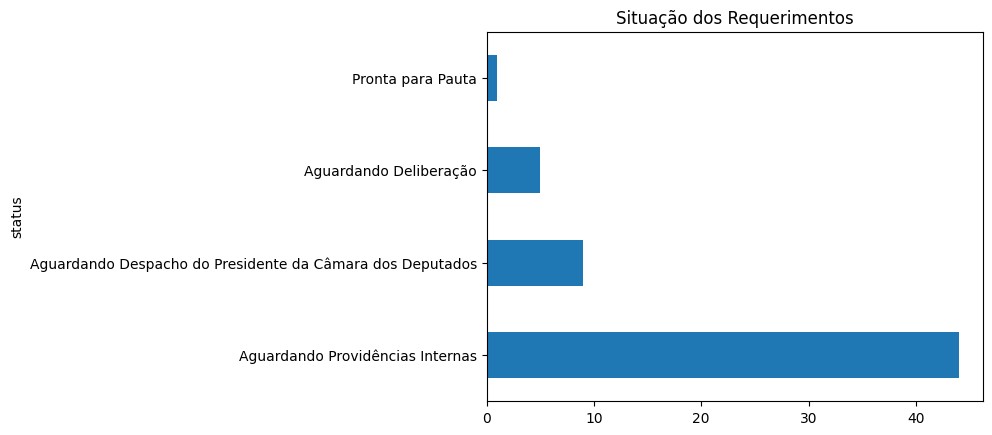

In [27]:
motions["status"].value_counts().plot(kind="barh", title="Situação dos Requerimentos")


Temos uma grande predominância do Status "Aguardando Providências Internas"

---

### Tratamento e Análise Exploratória com NLP para Eventos

Vamos partir agora para uma análise focada em NLP, para isso devemos tratar nossos dados textuais, e utilziar de técnicas como BoW, NER e Embeddings.

Para eventos vamos focar em duas colunas de interesse: descricao e topics (Pauta)



In [28]:
cleaned_events = events_with_topics.copy()

In [29]:
cleaned_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60 non-null     int64  
 1   uri             60 non-null     object 
 2   dataHoraInicio  60 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        60 non-null     object 
 5   descricaoTipo   60 non-null     object 
 6   descricao       60 non-null     object 
 7   localExterno    12 non-null     object 
 8   orgaos          60 non-null     object 
 9   localCamara     60 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         60 non-null     object 
 12  topics          13 non-null     object 
 13  comission       60 non-null     object 
 14  descricao_len   60 non-null     int64  
 15  topics_len      13 non-null     float64
dtypes: float64(3), int64(2), object(11)
memory usage: 7.6+ KB


In [30]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Aplicar em coluna de descrição (exemplo)
cleaned_events["descricao"] = cleaned_events["descricao"].fillna("").apply(preprocess_text)
cleaned_events["topics"] = cleaned_events["topics"].fillna("").apply(preprocess_text)


In [31]:
cleaned_events["descricao"].iloc[0]

'homenagem dia esporte homenagem dia esporte'

In [32]:
cleaned_events["num_words"] = cleaned_events["descricao"].apply(lambda x: len(x.split()))
cleaned_events["num_chars"] = cleaned_events["descricao"].apply(len)

print("Resumo das quantidades de palavras na descrição:")
print(cleaned_events["num_words"].describe())


Resumo das quantidades de palavras na descrição:
count     60.000000
mean      39.416667
std       40.600280
min        1.000000
25%        5.000000
50%       18.000000
75%       70.250000
max      145.000000
Name: num_words, dtype: float64


Top 20 palavras mais frequentes nas decrições:
[('confirmar', 96), ('nacional', 48), ('representante', 32), ('deputado', 28), ('público', 28), ('requerimento', 27), ('presidente', 26), ('discussão', 25), ('legislativo', 24), ('votação', 21), ('nº', 20), ('req', 20), ('trabalho', 18), ('saúde', 17), ('proposta', 17), ('Associação', 15), ('autoria', 15), ('união', 15), ('comissão', 14), ('brasileiro', 14)]


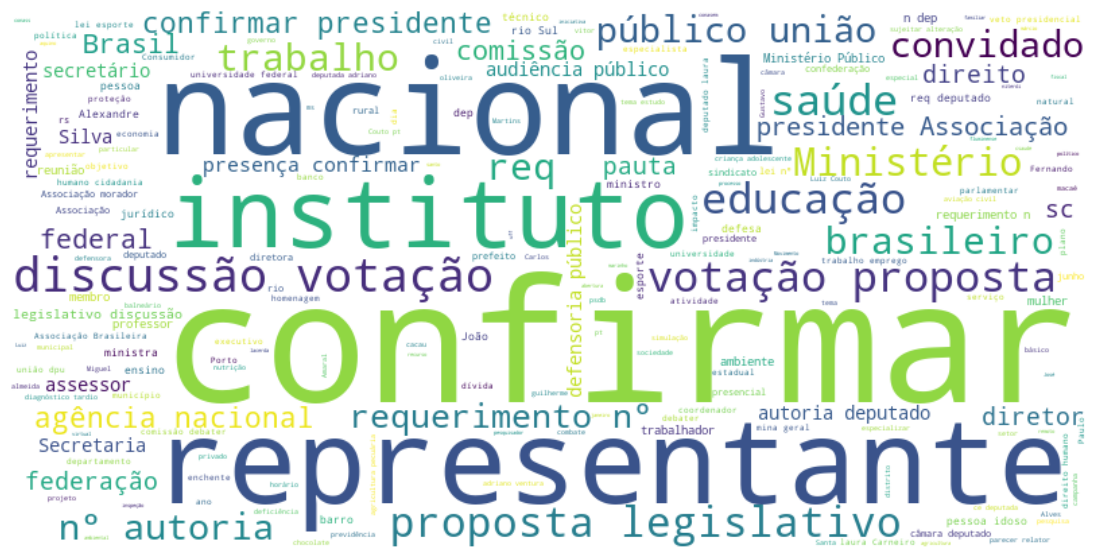

In [33]:
description = " ".join(cleaned_events["descricao"])

word_counts_descriptions = Counter(description.split())
print("Top 20 palavras mais frequentes nas decrições:")
print(word_counts_descriptions.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(description)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Top 20 palavras mais frequentes nas pautas:
[('nº', 217), ('lei', 155), ('deputado', 151), ('projeto', 128), ('pl', 126), ('parecer', 112), ('relator', 108), ('comissão', 76), ('aprovação', 75), ('legislativo', 74), ('substitutivo', 57), ('pauta', 56), ('apensar', 55), ('alterar', 53), ('público', 47), ('serviço', 44), ('nacional', 41), ('requerimento', 38), ('emenda', 38), ('relatora', 33)]


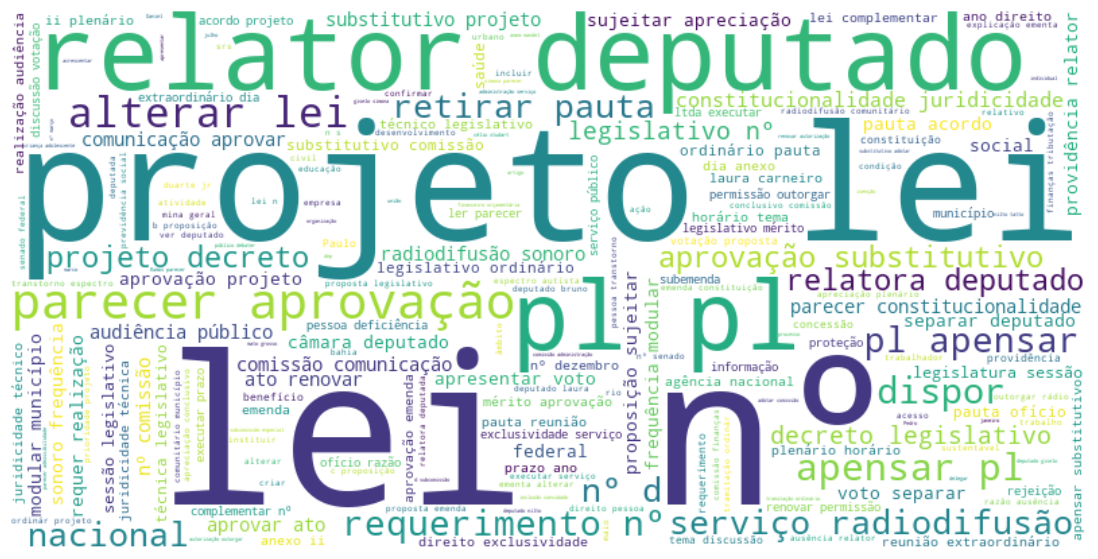

In [34]:
topics = " ".join(cleaned_events["topics"])

topics_word_counts = Counter(topics.split())
print("Top 20 palavras mais frequentes nas pautas:")
print(topics_word_counts.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topics)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Temos que em ambas Nuvens de palavras há muito a presença de jargões e palavras técnicas referentes a esses tipos de documento.

Vamos tentar identificar as entidades nomeadas

In [35]:
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

cleaned_events["entities"] = cleaned_events["descricao"].fillna("").apply(extract_ner)


In [36]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)


In [37]:
print("Tipos de entidade mais frequentes nas descrições:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nas descrições:
PER: 118 ocorrências
LOC: 68 ocorrências
ORG: 19 ocorrências
MISC: 9 ocorrências

Exemplos de entidades por tipo:
LOC: ['Estados Unidos América', 'Educação', 'coimbra', 'Lisboa', 'Campos']
PER: ['Juliane Mombelli', 'Miguel aragon assessor', 'Ramos', 'roberto almeida gil instituto nacional câncer inca', 'Geraldo']
ORG: ['Associação médico brasileiro amb carlar galego presencial federal nutrição cfn', 'psdb', 'Associação brasileiro', 'Banco Brasil', 'Fórum']
MISC: ['Gimenes', 'nºs', 'Am nº', 'Secretaria nacional Consumidor senacon', 'Ministério']


O tipo de entidade nomeada mais frequente é de Person (pessoas), seguido de localização.
Temos uma grande coletânea de diversos tipos de NER e da corretude delas a serem extraídas.

Fazendo o mesmo para as pautas temos:

In [38]:
cleaned_events["entities_topics"] = cleaned_events["topics"].fillna("").apply(extract_ner)

In [39]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities_topics"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

print("Tipos de entidade mais frequentes nas pautas:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")


Tipos de entidade mais frequentes nas pautas:
PER: 167 ocorrências
LOC: 56 ocorrências
MISC: 18 ocorrências
ORG: 4 ocorrências

Exemplos de entidades por tipo:
LOC: ['Portugal', 'Educação', 'Washington', 'Estados', 'atália']
ORG: ['cpd', 'assembleia legislativo mina geral', 'Kicis']
PER: ['Silvestre', 'gilson daniel', 'Juliane Mombelli', 'Ramos', 'Ribeiro']
MISC: ['Franca', 'nºs', 'Lei nº janeiro', 'Lei', 'Lei nº amom mandel alterar lei nº maio ampliar conceito']


Mantemos a predominância de pessoas seguido de localizações.

Vamos agora aplicar os dois campos de interesse para uma abordagem de embeddings, utilizando o distillBERT, com isso iremos verificar como os textos se distanciam no espaço vetorial para as diferentes comissões. Devido ao maior tamanho vamos aplicar isto apenas as Pautas.

In [ ]:
from transformers import (
    AutoModel,
    AutoTokenizer,
)

In [41]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Resgata tokenizador distilbert

In [42]:
def tokenize(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["topics"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [43]:
topics_embedding = cleaned_events[["topics", "comission"]].dropna()
topics_embedding = topics_embedding[topics_embedding["topics"] != ""].reset_index(drop=True)

In [44]:
topics_embedding_dataset = Dataset.from_pandas(topics_embedding)

In [45]:
topics_text_encoded = topics_embedding_dataset.map(
    tokenize,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Map: 100%|██████████| 13/13 [00:00<00:00, 136.18 examples/s]


Vamos usar agora o BERT como extrator de "features" a partir dos embeddings.

Os embeddings podem ser vistos como a representação inicial de uma palavra ou unidade de texto (seja ela estática ou contextuais).

Já os hidden states são as representações intermediárias mais complexas que o modelo constrói camada por camada, vamos extrair o hidden state dos embedding para o token [CLS] que contém informação de toda a sequência de texto.

Por estarmos lidando com poucos dados, não vai ser essencial o uso de uma GPU.

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [47]:
def extract_hidden_states(batch):

    # Repassa entradas do modelo para a GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad(): # Congela o modelo BERT, ou seja não calcula gradiente
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornamos os valore da camada oculta para a CPU como um array Numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

topics_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
topics_hidden_features = topics_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map: 100%|██████████| 13/13 [00:06<00:00,  2.03 examples/s]


In [48]:
topics_hidden_features.column_names

['topics', 'comission', 'input_ids', 'attention_mask', 'hidden_state']

In [49]:
topics_hidden_features

Dataset({
    features: ['topics', 'comission', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 13
})

In [50]:
y_topics = topics_hidden_features["comission"]
X_topics = topics_hidden_features.remove_columns(["topics", "comission"])


In [51]:
X_topics_scaled = MinMaxScaler().fit_transform(X_topics["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_topics_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_topics
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


,X,Y,label
0,17.839140,7.643317,Comissão Externa destinada a apurar e acompanh...
1,18.378948,6.326747,"Comissão de Indústria, Comércio e Serviços"
2,19.341219,6.687774,Comissão Especial destinada a proferir parecer...
3,19.101019,5.965913,Comissão de Defesa dos Direitos das Pessoas co...
4,18.865355,7.972513,Comissão de Minas e Energia


In [52]:
df_embedding

,X,Y,label
0,17.839140,7.643317,Comissão Externa destinada a apurar e acompanh...
1,18.378948,6.326747,"Comissão de Indústria, Comércio e Serviços"
2,19.341219,6.687774,Comissão Especial destinada a proferir parecer...
3,19.101019,5.965913,Comissão de Defesa dos Direitos das Pessoas co...
4,18.865355,7.972513,Comissão de Minas e Energia
5,19.309891,5.250768,Comissão de Administração e Serviço Público
6,18.359438,5.437131,Comissão de Desenvolvimento Econômico
7,19.843241,6.142120,Comissão de Meio Ambiente e Desenvolvimento Su...
8,19.996222,5.480434,Comissão de Finanças e Tributação
9,17.876749,5.946644,Comissão de Constituição e Justiça e de Cidadania


C:\Users\renne\AppData\Local\Temp\ipykernel_14928\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


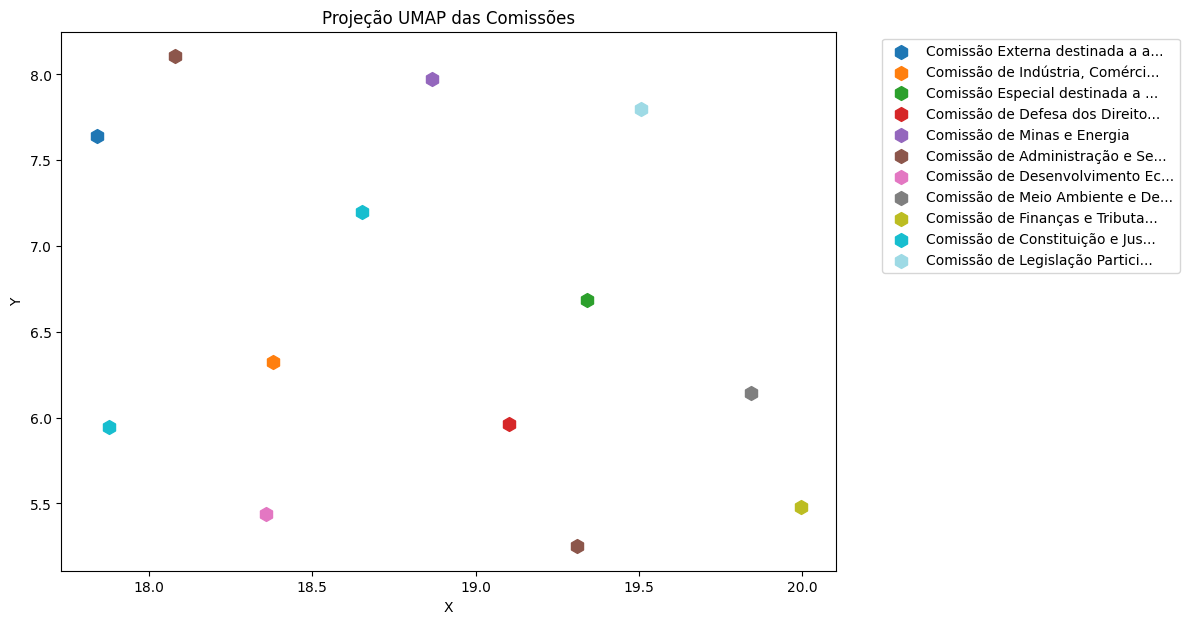

In [53]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [54]:
df_embedding[df_embedding["label"] == "Comissão de Segurança Pública e Combate ao Crime Organizado"].head()

,X,Y,label


In [55]:
events_with_aa = events_with_topics[~events_with_topics["topics"].isna()]

In [56]:
events_with_aa.iloc[5].topics

'Pauta - CASP - 15/07/2025 14:00\nCÂMARA DOS DEPUTADOS\nCOMISSÃO DE ADMINISTRAÇÃO E SERVIÇO PÚBLICO\n57ª Legislatura - 3ª Sessão Legislativa Ordinária\nPAUTA DE\nREUNIÃO EXTRAORDINÁRIA\nDIA 15/07/2025\nLOCAL:\nAnexo II, Plenário 08\nHORÁRIO:\n14h\nTEMA:\n"Discussão e votação de propostas legislativas"\n"Pauta sujeita a alterações."\nA -\nRequerimentos:\n1 -\nREQUERIMENTO Nº 57/2025\n- d\na Sra. Erika Kokay - que "requeiro a realização de um ciclo de seis audiências públicas, no âmbito da Comissão de Administração e Serviço Público, com temas de interesse das carreiras e do serviço público\n\n"\n2 -\nREQUERIMENTO Nº 58/2025\n- d\na Sra. Erika Kokay - que "requer aditamento ao REQ 057/2025, para a inclusão de convidados (as) ao ciclo de seis audiências públicas, no âmbito desta Comissão, com temas de interesse das carreiras e do serviço público".\n3 -\nREQUERIMENTO Nº 59/2025\n- d\no Sr. Icaro de Valmir - que "requer o aditamento ao requerimento nº 57/2025 para inclusão de novos convidad

Devemos agora fazer os mesmos procedimentos para os Requerimentos!

Percebemos uma grande similaridade nos embeddings semânticos para os textos utilizados, o que se sugere que há algum tipo de texto muito comum entre as pautas, provavelmente decorrente de jargões técnicos e estruturas definidas nos padrões dos documentos. Para uma melhor repassagem para a produção devemos retornar alguns passos atrás para a etapa de pré-processamento para limpar essas informações.

---

### Tratamento e Análise Exploratória com NLP para Requerimentos

Para os requerimentos vamos focar em sua ementa e texto completo em PDF



In [57]:
cleaned_motions = motions.copy()

In [58]:
cleaned_motions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   titulo      59 non-null     object
 1   uri         59 non-null     object
 2   event_id    59 non-null     int64 
 3   details     59 non-null     object
 4   status      59 non-null     object
 5   ementa      59 non-null     object
 6   pdf_url     59 non-null     object
 7   id          59 non-null     object
 8   pdf_text    59 non-null     object
 9   title_len   59 non-null     int64 
 10  ementa_len  59 non-null     int64 
 11  pdf_len     59 non-null     int64 
dtypes: int64(4), object(8)
memory usage: 5.7+ KB


In [60]:
# Aplicar em coluna de descrição (exemplo)
cleaned_motions["ementa"] = cleaned_motions["ementa"].fillna("").apply(preprocess_text)
cleaned_motions["pdf_text"] = cleaned_motions["pdf_text"].fillna("").apply(preprocess_text)


In [62]:
cleaned_motions["ementa"].iloc[0]

'requerer convocação sessão solene dia junho ano plenário casa homenagem dia esporte'

In [63]:
cleaned_motions["num_words"] = cleaned_motions["ementa"].apply(lambda x: len(x.split()))
cleaned_motions["num_chars"] = cleaned_motions["ementa"].apply(len)

print("Resumo das quantidades de palavras na ementa:")
print(cleaned_motions["num_words"].describe())


Resumo das quantidades de palavras na ementa:
count     59.000000
mean      29.355932
std       29.217828
min        9.000000
25%       13.000000
50%       18.000000
75%       39.500000
max      187.000000
Name: num_words, dtype: float64


Top 20 palavras mais frequentes nas ementas:
[('representante', 59), ('requerer', 54), ('realização', 50), ('público', 50), ('audiência', 43), ('nacional', 25), ('debater', 21), ('tecnologia', 20), ('brasileiro', 19), ('comissão', 18), ('convidar', 18), ('seguinte', 16), ('Brasil', 15), ('inteligência', 15), ('artificial', 15), ('direito', 14), ('discutir', 14), ('participação', 13), ('âmbito', 12), ('lei', 11)]


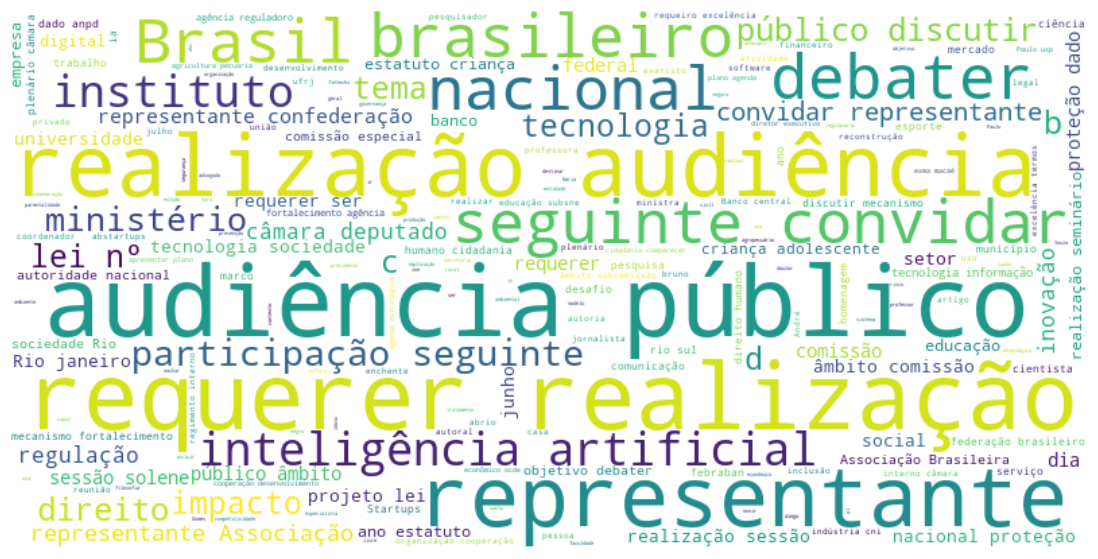

In [65]:
description = " ".join(cleaned_motions["ementa"])

word_counts_descriptions = Counter(description.split())
print("Top 20 palavras mais frequentes nas ementas:")
print(word_counts_descriptions.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(description)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Top 20 palavras mais frequentes nas pautas:
[('dep', 349), ('r', 343), ('n', 331), ('c', 249), ('s', 243), ('deputado', 231), ('p', 228), ('público', 225), ('d', 198), ('comissão', 190), ('representante', 177), ('t', 171), ('assinar', 168), ('eletronicamente', 165), ('verificar', 163), ('assinatura', 162), ('acer', 161), ('ã', 160), ('ç', 160), ('q', 160)]


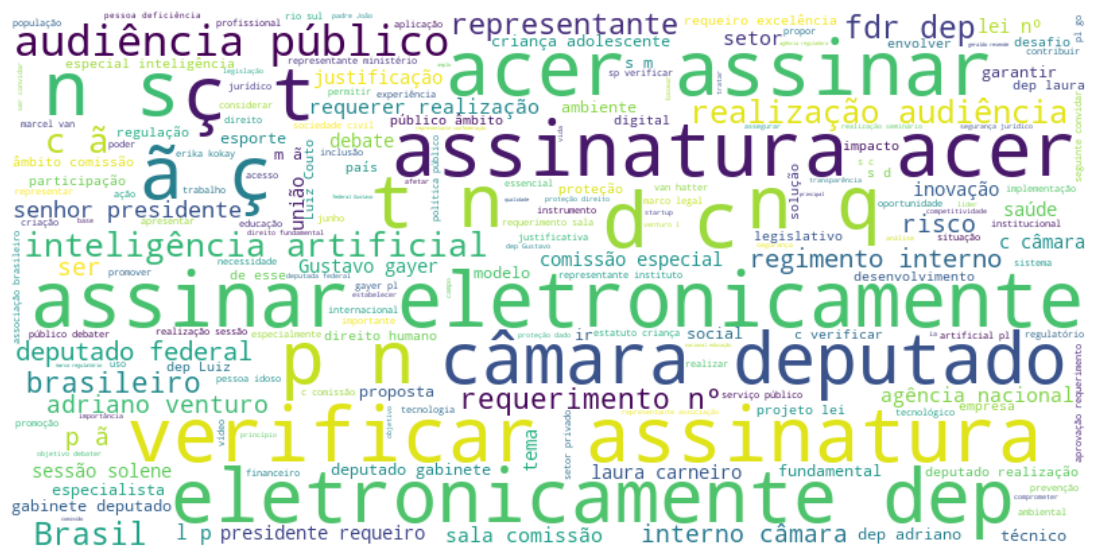

In [67]:
pdf_text = " ".join(cleaned_motions["pdf_text"])

pdf_text_word_counts = Counter(pdf_text.split())
print("Top 20 palavras mais frequentes nas pautas:")
print(pdf_text_word_counts.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pdf_text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
cleaned_motions["entities"] = cleaned_motions["ementa"].fillna("").apply(extract_ner)


In [70]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)


In [73]:
print("Tipos de entidade mais frequentes nas ementas:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nas ementas:
PER: 118 ocorrências
LOC: 68 ocorrências
ORG: 19 ocorrências
MISC: 9 ocorrências

Exemplos de entidades por tipo:
LOC: ['Estados Unidos América', 'Educação', 'coimbra', 'Lisboa', 'Campos']
PER: ['Juliane Mombelli', 'Miguel aragon assessor', 'Ramos', 'roberto almeida gil instituto nacional câncer inca', 'Geraldo']
ORG: ['Associação médico brasileiro amb carlar galego presencial federal nutrição cfn', 'psdb', 'Associação brasileiro', 'Banco Brasil', 'Fórum']
MISC: ['Gimenes', 'nºs', 'Am nº', 'Secretaria nacional Consumidor senacon', 'Ministério']


O tipo de entidade nomeada mais frequente é de Person (pessoas), seguido de localização.
Temos uma grande coletânea de diversos tipos de NER e da corretude delas a serem extraídas.

Fazendo o mesmo para as pautas temos:

In [74]:
cleaned_motions["entities_pdf_text"] = cleaned_motions["pdf_text"].fillna("").apply(extract_ner)

In [79]:
comissoes_dict = cleaned_events.set_index('id')['comission']

# Adiciona a nova coluna com base no id
cleaned_motions['comission'] = cleaned_motions['event_id'].map(comissoes_dict)

In [76]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_motions["entities_pdf_text"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

print("Tipos de entidade mais frequentes nos pdfs:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")


Tipos de entidade mais frequentes nos pdfs:
PER: 430 ocorrências
LOC: 250 ocorrências
MISC: 156 ocorrências
ORG: 66 ocorrências

Exemplos de entidades por tipo:
PER: ['andré passaro', 'padre João i', 'roberto almeida gil instituto nacional câncer', 'Moreira', 'flávio oliveira']
LOC: ['merlong', 'universidade federal abc', 'federação comércio', 'Maligna', 'Instituto ayrton senna']
MISC: ['d c d', 'd p u t d', 'Vieira melo pp es dep mário Heringer', 'Ramos', 'Marcelo']
ORG: ['PP', 'gisela simona', 'petrobrás', 'petrone', 'ocde']


Mantemos a predominância de pessoas seguido de localizações.

Vamos agora aplicar os dois campos de interesse para uma abordagem de embeddings, utilizando o distillBERT, com isso iremos verificar como os textos se distanciam no espaço vetorial para as diferentes comissões. Devido ao maior tamanho vamos aplicar isto apenas as Pautas.

In [85]:
def tokenize_motions(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["ementa"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [81]:
motions_embedding = cleaned_motions[["ementa", "comission"]].dropna()
motions_embedding = motions_embedding[motions_embedding["ementa"] != ""].reset_index(drop=True)

In [82]:
motions_embedding_dataset = Dataset.from_pandas(motions_embedding)

In [86]:
motions_text_encoded = motions_embedding_dataset.map(
    tokenize_motions,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map: 100%|██████████| 59/59 [00:00<00:00, 3809.66 examples/s]


Vamos usar agora o BERT como extrator de "features" a partir dos embeddings.

Os embeddings podem ser vistos como a representação inicial de uma palavra ou unidade de texto (seja ela estática ou contextuais).

Já os hidden states são as representações intermediárias mais complexas que o modelo constrói camada por camada, vamos extrair o hidden state dos embedding para o token [CLS] que contém informação de toda a sequência de texto.

Por estarmos lidando com poucos dados, não vai ser essencial o uso de uma GPU.

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [90]:
motions_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
motions_hidden_features = motions_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map: 100%|██████████| 59/59 [00:27<00:00,  2.16 examples/s]


In [91]:
motions_hidden_features.column_names

['ementa', 'comission', 'input_ids', 'attention_mask', 'hidden_state']

In [92]:
motions_hidden_features

Dataset({
    features: ['ementa', 'comission', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 59
})

In [96]:
y_motions = motions_hidden_features["comission"]
X_motions = motions_hidden_features.remove_columns(["ementa", "comission"])

In [97]:
X_motions_scaled = MinMaxScaler().fit_transform(X_motions["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_motions_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_motions
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,-1.304527,2.773768,Plenário
1,-0.202204,2.566008,Plenário
2,1.949085,3.262528,Comissão de Defesa do Consumidor
3,-1.743910,-1.550917,Comissão de Meio Ambiente e Desenvolvimento Su...
4,0.087629,2.908777,"Comissão de Agricultura, Pecuária, Abastecimen..."


In [98]:
df_embedding

,X,Y,label
0,-1.304527,2.773768,Plenário
1,-0.202204,2.566008,Plenário
2,1.949085,3.262528,Comissão de Defesa do Consumidor
3,-1.743910,-1.550917,Comissão de Meio Ambiente e Desenvolvimento Su...
4,0.087629,2.908777,"Comissão de Agricultura, Pecuária, Abastecimen..."
5,-0.016491,4.284503,Comissão de Saúde
6,1.805630,4.117227,Comissão de Saúde
7,1.637122,4.361721,Subcomissão Permanente para tratar do Sistema ...
8,0.375336,4.034699,Subcomissão Permanente para tratar do Sistema ...
9,1.569464,4.056150,Subcomissão Permanente para tratar do Sistema ...


C:\Users\renne\AppData\Local\Temp\ipykernel_14928\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


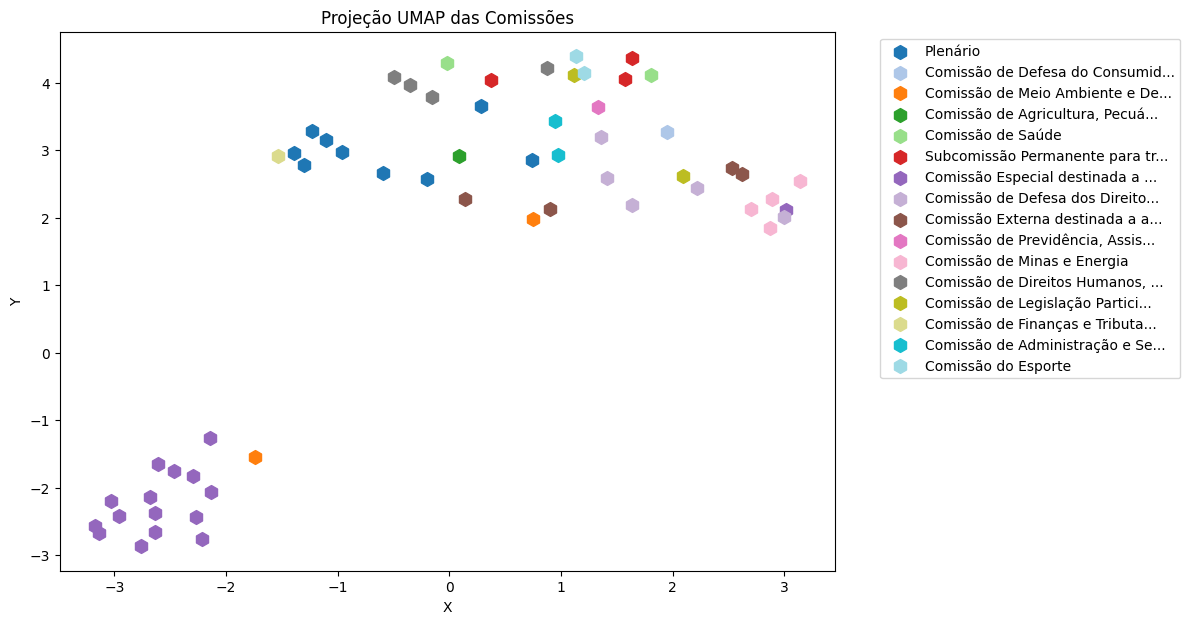

In [99]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [100]:
def tokenize_pdf(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["pdf_text"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["comission"] = batch["comission"]

  return encodings

In [101]:
motions_embedding = cleaned_motions[["pdf_text", "comission"]].dropna()
motions_embedding = motions_embedding[motions_embedding["pdf_text"] != ""].reset_index(drop=True)

In [102]:
motions_embedding_dataset = Dataset.from_pandas(motions_embedding)

In [104]:
motions_text_encoded = motions_embedding_dataset.map(
    tokenize_pdf,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map: 100%|██████████| 59/59 [00:00<00:00, 1755.23 examples/s]


Vamos usar agora o BERT como extrator de "features" a partir dos embeddings.

Os embeddings podem ser vistos como a representação inicial de uma palavra ou unidade de texto (seja ela estática ou contextuais).

Já os hidden states são as representações intermediárias mais complexas que o modelo constrói camada por camada, vamos extrair o hidden state dos embedding para o token [CLS] que contém informação de toda a sequência de texto.

Por estarmos lidando com poucos dados, não vai ser essencial o uso de uma GPU.

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [106]:
motions_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "comission"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
motions_hidden_features = motions_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map: 100%|██████████| 59/59 [00:31<00:00,  1.86 examples/s]


In [107]:
motions_hidden_features.column_names

['pdf_text', 'comission', 'input_ids', 'attention_mask', 'hidden_state']

In [108]:
motions_hidden_features

Dataset({
    features: ['pdf_text', 'comission', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 59
})

In [109]:
y_motions = motions_hidden_features["comission"]
X_motions = motions_hidden_features.remove_columns(["pdf_text", "comission"])

In [110]:
X_motions_scaled = MinMaxScaler().fit_transform(X_motions["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_motions_scaled)

df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_motions
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,8.075309,-1.618039,Plenário
1,6.263304,0.610482,Plenário
2,7.441971,-1.780771,Comissão de Defesa do Consumidor
3,7.953672,-1.912682,Comissão de Meio Ambiente e Desenvolvimento Su...
4,5.822028,-2.358130,"Comissão de Agricultura, Pecuária, Abastecimen..."


In [111]:
df_embedding

,X,Y,label
0,8.075309,-1.618039,Plenário
1,6.263304,0.610482,Plenário
2,7.441971,-1.780771,Comissão de Defesa do Consumidor
3,7.953672,-1.912682,Comissão de Meio Ambiente e Desenvolvimento Su...
4,5.822028,-2.358130,"Comissão de Agricultura, Pecuária, Abastecimen..."
5,5.329240,-2.064704,Comissão de Saúde
6,5.502213,-1.611744,Comissão de Saúde
7,6.430411,-2.844754,Subcomissão Permanente para tratar do Sistema ...
8,6.680057,-2.126599,Subcomissão Permanente para tratar do Sistema ...
9,7.041748,-3.403511,Subcomissão Permanente para tratar do Sistema ...


C:\Users\renne\AppData\Local\Temp\ipykernel_14928\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


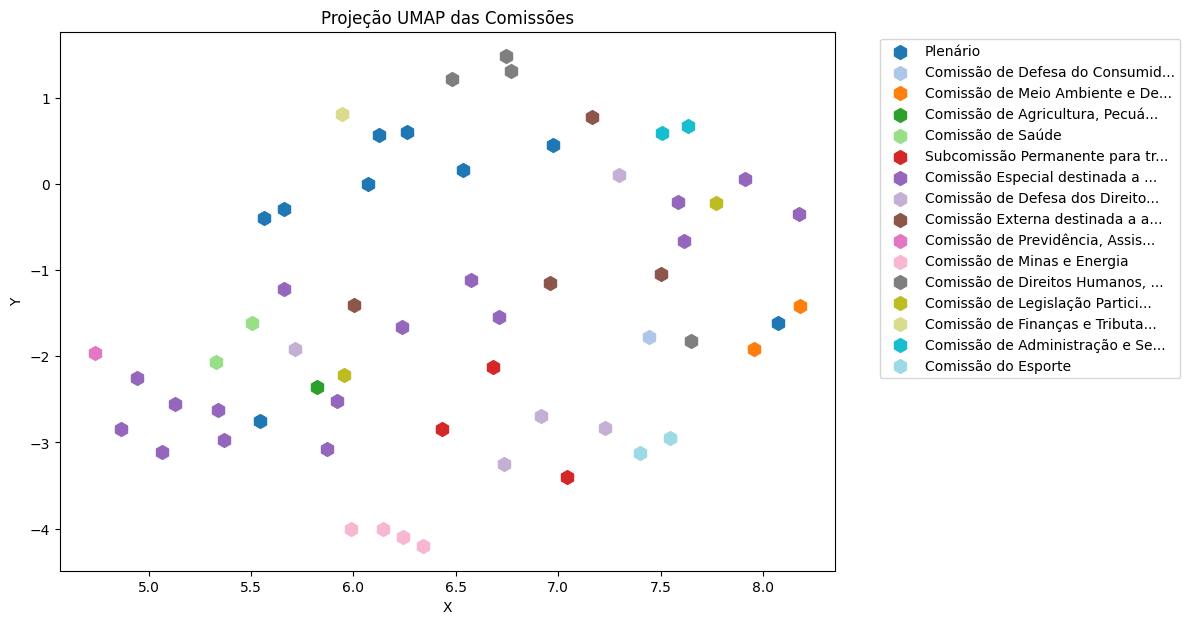

In [112]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Com os requerimentos conseguimos ver muito melhor a divisão dos temas utilizando as ementas! Invés das Pautas que apresentam muitos nulos e informações desnecessárias, vamos utilizá-los para nossa tarefa de identificação.


Os textos em PDF mesmo possuind clusters muito bem definidos também apresenta diversos textos que "se misturam", cabe a tentativa de tratar esses dados removendo seus jargões técnicos.

É possível realizar uma abordagem de similaridade dupla, caso a ementa e o requerimento estejam alinhados com o tema desejado.

Os processamentos aqui realizados que constroem os embeddings serão repassados para scripts Python de forma modular.